In [16]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.linalg import pinv
from itertools import product
import numpy as np, h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
%matplotlib inline
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np


In [15]:
gene_names = pd.read_csv("genes.csv")["gene"].to_numpy()
cell_names = pd.read_csv("foreground_cells.csv")["cell"].to_numpy()
foreground = pd.read_csv("foreground_matrix.csv", index_col=0)
background = pd.read_csv("background_matrix (5).csv", index_col = 0)

cell_types= pd.read_csv("cell_types_foreground.csv")['cell_type'].values

X = foreground.to_numpy()
Y = background.to_numpy()


In [4]:
from main import*


In [8]:
cols_contrastive, rows_contrastive, hist = iccur(
       X, Y, cols=20, rows=200, k=7,
       max_iter=100, epsilon=1e-6,
       theta_S=0.90, theta_T=0.90, patience=2,
       verbose=True
 )
gene_names[cols_contrastive]

array(['ENSG00000227811', 'ENSG00000240386', 'ENSG00000186226',
       'ENSG00000197084', 'ENSG00000196734', 'ENSG00000137473',
       'ENSG00000095970', 'ENSG00000148357', 'ENSG00000170835',
       'ENSG00000166257', 'ENSG00000134545', 'ENSG00000135423',
       'ENSG00000183273', 'ENSG00000229723', 'ENSG00000182950',
       'ENSG00000186994', 'ENSG00000186115', 'ENSG00000259436',
       'ENSG00000204941', 'ENSG00000188624'], dtype=object)

In [9]:
r = 200
k = 7
foreground_indices = deterministic_cur(X,k, r)[4]

/nas/longleaf/home/eyzhang/.local/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 1000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


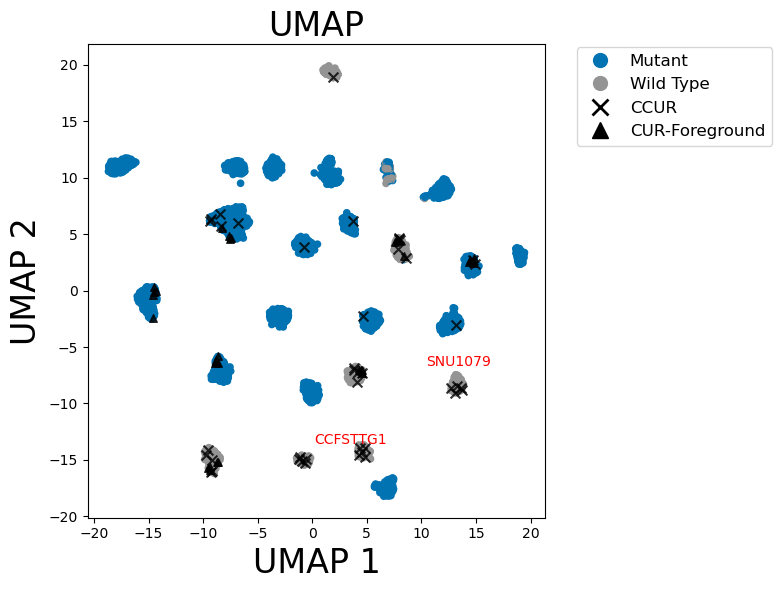

In [12]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap

cell_type_map = {
    'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM': 'CCFSTTG1',
    'COV434_OVARY': 'COV434',
    'DKMG_CENTRAL_NERVOUS_SYSTEM': 'DKMG',
    'LNCAPCLONEFGC_PROSTATE': 'LNCAPCLONEFGC',
    'NCIH226_LUNG': 'NCIH226',
    'RCC10RGB_KIDNEY': 'RCC10RGB',
    'SNU1079_BILIARY_TRACT': 'SNU1079'
}

cell_types_short = pd.Series(cell_types).map(cell_type_map).fillna(pd.Series(cell_types)).values

adata = sc.AnnData(foreground.values)
adata.obs['barcode'] = foreground.index 
adata.var['gene_name'] = foreground.columns 

adata.obs['cell_types'] = pd.Categorical(cell_types_short)  

selected_cell_types = ['CCFSTTG1', 'COV434', 'DKMG', 'LNCAPCLONEFGC', 'NCIH226', 'RCC10RGB', 'SNU1079']
adata.obs['Group'] = adata.obs['cell_types'].apply(
    lambda x: 'Wild Type' if x in selected_cell_types else 'Mutant'
)

adata.obs['Group'] = pd.Categorical(adata.obs['Group'])

sc.pp.neighbors(adata, n_neighbors=30) 
sc.tl.umap(adata)

coords = adata.obsm['X_umap']
groups = adata.obs['Group']

colorblind_palette = sns.color_palette("colorblind")
colors = [colorblind_palette[0], colorblind_palette[7]]  

palette = ListedColormap(colors)

def sample_indices_per_cell_type(indices, cell_types, max_markers=5):
    sampled_indices = []
    for cell_type in cell_types.cat.categories: 
        cell_type_indices = [
            idx for idx in indices
            if adata.obs.iloc[idx]['cell_types'] == cell_type  
        ]
        if len(cell_type_indices) > 0:
            sampled_indices.extend(
                np.random.choice(cell_type_indices, size=min(len(cell_type_indices), max_markers), replace=False)
            )
    return sampled_indices

contrastive_indices_capped = sample_indices_per_cell_type(rows_contrastive, adata.obs['cell_types'])

foreground_indices_capped = sample_indices_per_cell_type(foreground_indices, adata.obs['cell_types'])

plt.figure(figsize=(8, 6))  
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=groups.cat.codes, cmap=palette, s=20, alpha=1)

plt.scatter(coords[contrastive_indices_capped, 0], coords[contrastive_indices_capped, 1], 
            color='black', marker='x', s=50, label='Contrastive', alpha=0.8)

plt.scatter(coords[foreground_indices_capped, 0], coords[foreground_indices_capped, 1], 
            color='black', marker='^', s=30, label='CUR-Foreground', alpha=0.8)

highlighted_cell_types = ['SNU1079', 'CCFSTTG1', 'DKMG']
labeled_cell_types = set()  

for cell_type in highlighted_cell_types:
    indices = adata.obs.index[adata.obs['cell_types'] == cell_type]
    cell_coords = coords[[int(idx) for idx in indices], :]
    
    if cell_type == 'DKMG':
        target_x_range = (6, 10)
        target_y_range = (-20, -16)
        second_dkmg_coords = cell_coords[
            (cell_coords[:, 0] >= target_x_range[0]) & (cell_coords[:, 0] <= target_x_range[1]) &
            (cell_coords[:, 1] >= target_y_range[0]) & (cell_coords[:, 1] <= target_y_range[1])
        ]
        for x, y in second_dkmg_coords:
            plt.text(x, y + 1.9, 'DKMG', fontsize=10, color='red', ha='center', va='center')  
            break  

    elif cell_type == 'CCFSTTG1' and cell_type not in labeled_cell_types:
        for x, y in cell_coords:
            plt.text(x - 1.5, y + 1.3, cell_type, fontsize=10, color='red', ha='center', va='center')
            labeled_cell_types.add(cell_type)
            break  

    elif cell_type not in labeled_cell_types:
        for x, y in cell_coords:
            plt.text(x, y + 1.3, cell_type, fontsize=10, color='red', ha='center', va='center')
            labeled_cell_types.add(cell_type)
            break  

handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None', color='w', markerfacecolor=colors[0],
               markersize=12, label='Mutant'),
    plt.Line2D([0], [0], marker='o', linestyle='None', color='w', markerfacecolor=colors[1],
               markersize=12, label='Wild Type'),
    plt.Line2D([0], [0], marker='x', linestyle='None', color='black', markersize=12, markeredgewidth = 2, label='CCUR'),
    plt.Line2D([0], [0], marker='^', linestyle='None', color='black', markersize=12, label='CUR-Foreground')  # Orange triangle
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 0.89), loc='center left', fontsize=12)

plt.title("UMAP", fontsize=24)
plt.xlabel("UMAP 1", fontsize=24)
plt.ylabel("UMAP 2", fontsize=24)

plt.tight_layout()
os.chdir('/nas/longleaf/home/eyzhang/ccur/Small Molecules')
#plt.savefig('sm_rows.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
cell_type_assignments = adata.obs['cell_types']

contrastive_type_counts = cell_type_assignments[rows_contrastive].value_counts()
foreground_type_counts = cell_type_assignments[foreground_indices].value_counts()
true_type_counts = adata.obs['cell_types'].value_counts()

total_contrastive = len(rows_contrastive)
total_foreground = len(foreground_indices)

contrastive_proportions = contrastive_type_counts / total_contrastive
foreground_proportions = foreground_type_counts / total_foreground
total_cells = len(adata)
true_type_proportions = true_type_counts / total_cells

proportions_df = pd.DataFrame({
    'CCUR': contrastive_proportions,
    'CUR': foreground_proportions
})
proportions_df['True Proportion'] = true_type_proportions

proportions_df = proportions_df[(proportions_df).any(axis=1)]
print(proportions_df)

                                   CCUR    CUR  True Proportion
cell_types                                                     
BICR31_UPPER_AERODIGESTIVE_TRACT  0.045  0.020         0.089470
BICR6_UPPER_AERODIGESTIVE_TRACT   0.005  0.000         0.035853
BT474_BREAST                      0.000  0.000         0.022933
BT549_BREAST                      0.000  0.000         0.042313
CAOV3_OVARY                       0.005  0.000         0.045220
CCFSTTG1                          0.085  0.000         0.024871
COLO680N_OESOPHAGUS               0.005  0.000         0.041667
COV434                            0.005  0.000         0.024225
DKMG                              0.025  0.000         0.030039
IALM_LUNG                         0.000  0.000         0.045543
LNCAPCLONEFGC                     0.145  0.410         0.036499
LS1034_LARGE_INTESTINE            0.010  0.035         0.037791
NCIH226                           0.270  0.025         0.030362
NCIH2347_LUNG                     0.005 

/tmp/eyzhang/22474373/g1416ood07.ll.unc.edu/ipykernel_1965129/708105468.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contrastive_type_counts = cell_type_assignments[rows_contrastive].value_counts()
/tmp/eyzhang/22474373/g1416ood07.ll.unc.edu/ipykernel_1965129/708105468.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  foreground_type_counts = cell_type_assignments[foreground_indices].value_counts()
